## Set up WANDDB

In [1]:
%pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import wandb

wandb.login()
wandb.init(project='plant_disease_detection', name='disease_severity', entity='plant_disease_detection', reinit=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: leteutz (plant_disease_detection). Use `wandb login --relogin` to force relogin


In [3]:
# Is the notebook running in an online environment?
ONLINE_NOTEBOOK = True

In [4]:
import torch
from torch import nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data.dataset import Dataset, random_split
import os
import cv2  # Assuming we use OpenCV for image reading
import matplotlib.pyplot as plt
import numpy as np

class DiaMOSDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, imputation_value=-1):
        self.data = []
        self.img_dir = img_dir
        self.transform = transform
        self.imputation_value = imputation_value
        
        if ONLINE_NOTEBOOK:
            csv_file_path = os.path.join('/kaggle/input/diamos-plant-dataset/Pear/annotation/csv', csv_file)  # Adapt based on download location
        else:
            csv_file_path = os.path.join('data\\Pear\\annotation\\csv\\', csv_file)  

        with open(csv_file_path, 'r') as f:
            lines = f.readlines()
            header = lines[0].strip().split(';')
            for line in lines[1:]:
                datapoint = dict(zip(header, line.strip().split(';')))
                
                disease = []
                disease.append(int(datapoint['healthy']))
                disease.append(int(datapoint['pear_slug']))
                disease.append(int(datapoint['leaf_spot']))
                disease.append(int(datapoint['curl']))

                severity = []
                for i in range(5):
                    value = datapoint[f'severity_{i}']
                    if value.lower() == 'not estimable':
                        severity.append(self.imputation_value)
                    else:
                        severity.append(int(value))

                self.data.append((datapoint['filename'], disease, severity))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename, disease, severity = self.data[idx]

        image_path = None
        for subfolder in ['curl', 'healthy', 'slug', 'spot']:
            potential_path = os.path.join(self.img_dir, subfolder, filename)
            if os.path.exists(potential_path):
                image_path = potential_path
                break

        if image_path is None:
            raise Exception(f"Image not found: {filename}")

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        image = Image.fromarray(image) 
        if self.transform:
            image = self.transform(image)

        disease_label = torch.tensor(disease, dtype=torch.int)
        severity_label = torch.tensor(severity, dtype=torch.int)

        return image, disease_label, severity_label

In [5]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if ONLINE_NOTEBOOK:
    full_dataset = DiaMOSDataset(csv_file='diaMOSPlant.csv', img_dir='/kaggle/input/diamos-plant-dataset/Pear/leaves', transform=data_transform)
else:
    full_dataset = DiaMOSDataset(csv_file='diaMOSPlant.csv', img_dir='/data/Pear/leaves', transform=data_transform)

train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
#TODO: How many batches?
batch_size = 16

train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [6]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [7]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [8]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = np.argmax(labels, axis=1).flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Disease Severity Model

In [9]:
class DiseaseSeverityModel(nn.Module):
    def __init__(self, num_disease_classes, num_severity_levels):
        super(DiseaseSeverityModel, self).__init__()
        vgg19 = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
        for param in vgg19.features.parameters(): param.requires_grad = False
        self.features = vgg19.features
        self.avgpool = vgg19.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
        )
        self.disease_classifier = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_disease_classes),
        )
        self.severity_classifier = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_severity_levels),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        disease_output = self.disease_classifier(x)
        severity_output = self.severity_classifier(x)
        return disease_output, severity_output



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)    

model = DiseaseSeverityModel(num_disease_classes=4, num_severity_levels=5)
model.to(device)
wandb.watch(model)

criterion = nn.CrossEntropyLoss()  

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize avg_val_loss
avg_val_loss = 0

# Training loop
epochs = 10
best_val_loss = float('inf')  # Initialize the best validation loss

# Measure the total training time for the whole run
total_t0 = time.time()
early_stopping = EarlyStopping(patience=2, verbose=True)

for epoch in range(epochs):
    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')
    
    # Measure how long the training epoch takes.
    t0 = time.time()
    
    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questimport gensim.downloader as api
    model.train()
    
    # Reset the total loss for this epoch.
    total_train_accuracy_disease = 0
    total_train_accuracy_severity = 0
    running_loss = 0.0
    
    # for images, disease_labels, severity_labels in train_data:
    # For each batch of training data...
    for step, batch in enumerate(train_data):
        
        # print(batch)
        
        # Progress update every 4 batches
        if step % 4 == 0 and not step == 0:
            # Calculate elapsed time in minutes
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_data), elapsed))
        
        images = batch[0].to(device)
        disease_labels = batch[1].to(device)
        severity_labels = batch[2].to(device)
        # images, disease_labels, severity_labels = images.to(device), disease_labels.to(device), severity_labels.to(device)
        
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        optimizer.zero_grad()
        
        disease_output, severity_output = model(images)
        
        disease_loss = criterion(disease_output, torch.argmax(disease_labels, dim=1))
        severity_loss = criterion(severity_output, torch.argmax(severity_labels, dim=1))
        
        loss = disease_loss + severity_loss
        wandb.log({"loss": loss.item(), "val_loss": avg_val_loss})
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        
        logits_disease = disease_output.detach().cpu().numpy()
        logits_severity = severity_output.detach().cpu().numpy()
        
        disease_label_ids = disease_labels.to('cpu').numpy()
        severity_label_ids = severity_labels.to('cpu').numpy()
        
        total_train_accuracy_disease += flat_accuracy(logits_disease, disease_label_ids)
        total_train_accuracy_severity += flat_accuracy(logits_severity, severity_label_ids)
        
    avg_train_accuracy_disease = total_train_accuracy_disease / len(train_data)
    print(" Train Accuracy - Disease: {0:.2f}".format(avg_train_accuracy_disease))
        
    avg_train_accuracy_severity = total_train_accuracy_severity / len(train_data)
    print(" Train Accuracy - Severity: {0:.2f}".format(avg_train_accuracy_severity))
    
    wandb.log({
        "loss": loss.item(),
        "train_accuracy_disease": avg_train_accuracy_disease,
        "train_accuracy_severity": avg_train_accuracy_severity,
    })

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")
    
    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    
    # with torch.no_grad():
    val_loss = 0.0
    # for images, disease_labels, severity_labels in val_data:
    # For each batch of training data...

    total_val_accuracy_disease = 0
    total_val_accuracy_severity = 0

    for _, batch in enumerate(val_data):   
            
        images = batch[0].to(device)
        disease_labels = batch[1].to(device)
        severity_labels = batch[2].to(device)
        
        # images, disease_labels, severity_labels = images.to(device), disease_labels.to(device), severity_labels.to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            disease_output, severity_output = model(images)
            
        disease_loss = criterion(disease_output, torch.argmax(disease_labels, dim=1))
        severity_loss = criterion(severity_output, torch.argmax(severity_labels, dim=1))
        val_loss += (disease_loss + severity_loss).item()

        logits_disease = disease_output.detach().cpu().numpy()
        logits_severity = severity_output.detach().cpu().numpy()
        
        disease_label_ids = disease_labels.to('cpu').numpy()
        severity_label_ids = severity_labels.to('cpu').numpy()
        
        total_val_accuracy_disease += flat_accuracy(logits_disease, disease_label_ids)
        total_val_accuracy_severity += flat_accuracy(logits_severity, severity_label_ids)


    avg_val_loss = val_loss / len(val_data)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_data)}, Validation Loss: {avg_val_loss}")
    
    avg_val_accuracy_disease = total_val_accuracy_disease / len(val_data)
    avg_val_accuracy_severity = total_val_accuracy_severity / len(val_data)

    print(" Validation Accuracy - Disease: {0:.2f}".format(avg_val_accuracy_disease))
    print(" Validation Accuracy - Severity: {0:.2f}".format(avg_val_accuracy_severity))

    # Log metrics to wandb
    wandb.log({
        "val_loss": avg_val_loss,
        "val_accuracy_disease": avg_val_accuracy_disease,
        "val_accuracy_severity": avg_val_accuracy_severity,
    })
    
    # Check if validation loss has improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "disease_severity_model.pth")  # Save the model
        wandb.save("disease_severity_model.pth")

    # Perform early stopping
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

# Load the best model
# model.load_state_dict(torch.load("disease_severity_model.pth"))

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Using device: cuda


Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 173MB/s]  



======== Epoch 1 / 10 ========
Training...
  Batch     4  of    113.    Elapsed: 0:00:14.
  Batch     8  of    113.    Elapsed: 0:00:23.
  Batch    12  of    113.    Elapsed: 0:00:33.
  Batch    16  of    113.    Elapsed: 0:00:42.
  Batch    20  of    113.    Elapsed: 0:00:52.
  Batch    24  of    113.    Elapsed: 0:01:01.
  Batch    28  of    113.    Elapsed: 0:01:11.
  Batch    32  of    113.    Elapsed: 0:01:21.
  Batch    36  of    113.    Elapsed: 0:01:31.
  Batch    40  of    113.    Elapsed: 0:01:41.
  Batch    44  of    113.    Elapsed: 0:01:49.
  Batch    48  of    113.    Elapsed: 0:01:59.
  Batch    52  of    113.    Elapsed: 0:02:09.
  Batch    56  of    113.    Elapsed: 0:02:18.
  Batch    60  of    113.    Elapsed: 0:02:28.
  Batch    64  of    113.    Elapsed: 0:02:39.
  Batch    68  of    113.    Elapsed: 0:02:49.
  Batch    72  of    113.    Elapsed: 0:02:59.
  Batch    76  of    113.    Elapsed: 0:03:09.
  Batch    80  of    113.    Elapsed: 0:03:20.
  Batch    84  o

In [13]:
# Evaluation loop (for validation or test data)
# model.eval()

# Add code for evaluation here (using validation or test data)
total_disease_correct = 0
total_severity_correct = 0
total_samples = 0

# Initialize lists to store correctly classified images (to print them in the next cell)
correct_images = []
correct_disease_labels = []
correct_severity_labels = []
correct_disease_predictions = []
correct_severity_predictions = []

with torch.no_grad():
    for images, disease_labels, severity_labels in test_data:
        images, disease_labels, severity_labels = images.to(device), disease_labels.to(device), severity_labels.to(device)
        disease_output, severity_output = model(images)
        
        # Disease classification
        _, disease_predicted = torch.max(disease_output, 1)
        disease_correct = (disease_predicted == torch.argmax(disease_labels, dim=1))
        total_disease_correct += disease_correct.sum().item()
        
        # Severity classification
        _, severity_predicted = torch.max(severity_output, 1)
        severity_correct = (severity_predicted == torch.argmax(severity_labels, dim=1))
        total_severity_correct += severity_correct.sum().item()
        
        total_samples += images.size(0)

        # Find indices of correctly classified images
        correct_indices = (disease_correct & severity_correct).nonzero().squeeze()

        # Check if correct_indices is a scalar
        if correct_indices.dim() == 0:
            correct_indices = [correct_indices.item()]

        # Append correctly classified images and their labels/predictions
        correct_images.extend(images[correct_indices].cpu().numpy())
        correct_disease_labels.extend(disease_labels[correct_indices].cpu().numpy())
        correct_severity_labels.extend(severity_labels[correct_indices].cpu().numpy())
        correct_disease_predictions.extend(disease_predicted[correct_indices].cpu().numpy())
        correct_severity_predictions.extend(severity_predicted[correct_indices].cpu().numpy())

disease_accuracy = total_disease_correct / total_samples
severity_accuracy = total_severity_correct / total_samples

print(f'Disease Classification Accuracy: {disease_accuracy * 100:.2f}%')
print(f'Severity Classification Accuracy: {severity_accuracy * 100:.2f}%')

# Log metrics to wandb
wandb.log({
    "test_accuracy_disease": disease_accuracy,
    "test_accuracy_severity": severity_accuracy,
})

# Save the trained model
torch.save(model.state_dict(), "disease_severity_model.pth")
wandb.save("disease_severity_model.pth")


Disease Classification Accuracy: 78.70%
Severity Classification Accuracy: 57.24%


['/kaggle/working/wandb/run-20240528_193830-gp3b3wn4/files/disease_severity_model.pth']

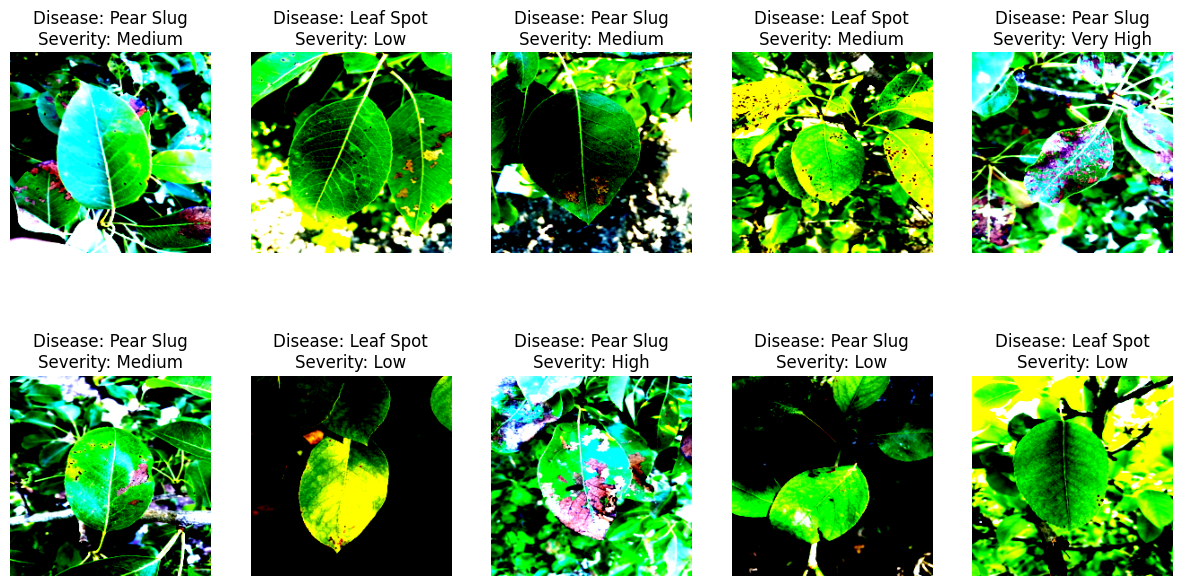

In [14]:
# Convert lists to numpy arrays
correct_images = np.array(correct_images)
correct_disease_labels = np.array(correct_disease_labels)
correct_severity_labels = np.array(correct_severity_labels)
correct_disease_predictions = np.array(correct_disease_predictions)
correct_severity_predictions = np.array(correct_severity_predictions)

# Show 10 correctly classified images along with their predictions
num_images_to_show = min(10, len(correct_images))
random_indices = np.random.choice(len(correct_images), num_images_to_show, replace=False)

fig, axs = plt.subplots(2, 5, figsize=(15, 7))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.flat):
    idx = random_indices[i]
    image = correct_images[idx]
    disease_label = ["Healthy", "Pear Slug", "Leaf Spot", "Curl"][correct_disease_predictions[idx]]
    severity_label = ["None", "Low", "Medium", "High", "Very High"][correct_severity_predictions[idx]]
    
    ax.imshow(np.moveaxis(image, 0, -1))  # Convert from (C, H, W) to (H, W, C)
    ax.set_title(f"Disease: {disease_label}\nSeverity: {severity_label}")
    ax.axis("off")

    # Log the image and its labels to wandb
    wandb.log({"correctly_classified_images": [wandb.Image(np.moveaxis(image, 0, -1), 
                                                         caption=f"Disease: {disease_label}\nSeverity: {severity_label}") 
                                               for image in correct_images[random_indices]]})

plt.show()

In [28]:
wandb.finish()
wandb.init(project='plant_disease_detection', name='disease_AND_severity', entity='plant_disease_detection', reinit=True)

# Combined labels approach

In [16]:
class DiaMOSDataset_Cartesian(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, imputation_value=-1):
        self.data = []
        self.img_dir = img_dir
        self.transform = transform
        self.imputation_value = imputation_value
        self.label_mapping = {}  # Mapping from (disease, severity) to unique integer
        self.label_counter = 0

        if ONLINE_NOTEBOOK:
            csv_file_path = os.path.join('/kaggle/input/diamos-plant-dataset/Pear/annotation/csv', csv_file)  # Adapt based on download location
        else:
            csv_file_path = os.path.join('data\\Pear\\annotation\\csv\\', csv_file)  

        with open(csv_file_path, 'r') as f:
            lines = f.readlines()
            header = lines[0].strip().split(';')
            for line in lines[1:]:
                datapoint = dict(zip(header, line.strip().split(';')))

                disease = np.argmax([int(datapoint['healthy']), int(datapoint['pear_slug']), 
                                     int(datapoint['leaf_spot']), int(datapoint['curl'])])

                severity = []
                for i in range(5):
                    value = datapoint[f'severity_{i}']
                    if value.lower() == 'not estimable':
                        severity.append(self.imputation_value)
                    else:
                        severity.append(int(value))
                severity = np.argmax(severity)

                combined_label = (disease, severity)
                if combined_label not in self.label_mapping:
                    self.label_mapping[combined_label] = self.label_counter
                    self.label_counter += 1

                self.data.append((datapoint['filename'], self.label_mapping[combined_label]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename, combined_label = self.data[idx]

        image_path = None
        for subfolder in ['curl', 'healthy', 'slug', 'spot']:
            potential_path = os.path.join(self.img_dir, subfolder, filename)
            if os.path.exists(potential_path):
                image_path = potential_path
                break

        if image_path is None:
            raise Exception(f"Image not found: {filename}")

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        image = Image.fromarray(image) 
        if self.transform:
            image = self.transform(image)

        return image, combined_label

In [17]:
# Define the data transformation
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the full dataset
if ONLINE_NOTEBOOK:
    full_dataset = DiaMOSDataset_Cartesian(csv_file='diaMOSPlant.csv', img_dir='/kaggle/input/diamos-plant-dataset/Pear/leaves', transform=data_transform)
else:
    full_dataset = DiaMOSDataset_Cartesian(csv_file='diaMOSPlant.csv', img_dir='/data/Pear/leaves', transform=data_transform)

# Split the dataset into training, validation, and test sets
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Define the batch size
batch_size = 16

# Create data loaders for the training, validation, and test sets
train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [22]:
class DiseaseSeverityModel_Combined(nn.Module):
    def __init__(self, num_combined_labels):
        super(DiseaseSeverityModel_Combined, self).__init__()
        vgg19 = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
        for param in vgg19.features.parameters(): param.requires_grad = False
        self.features = vgg19.features
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_combined_labels)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [25]:
# Initialize the model
num_combined_labels = 20  # Replace this with the actual number of combined labels
model = DiseaseSeverityModel_Combined(num_combined_labels)
model.to(device)
wandb.watch(model)

# Initialize the early_stopping object
early_stopping = EarlyStopping(patience=7, verbose=True, path='checkpoint.pt')

# Initialize val_loss_min to a high value
val_loss_min = float('inf')

# Training loop
for epoch in range(epochs):
    # Training
    model.train()
    total_train_accuracy = 0
    running_loss = 0.0
    for step, batch in enumerate(train_data):
        images = batch[0].to(device)
        combined_labels = batch[1].to(device)  # Assume that batch[1] contains the combined labels

        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, combined_labels)
        wandb.log({"loss": loss.item()})
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_labels = torch.max(output, 1)
        total_train_accuracy += (predicted_labels == combined_labels).sum().item()
        
        if step % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Step {step+1}/{len(train_data)}, Loss: {loss.item()}, Accuracy: {total_train_accuracy / ((step+1) * batch[0].size(0))}')

        
    avg_train_accuracy = total_train_accuracy / len(train_data.dataset)
    print(" Train Accuracy: {0:.2f}".format(avg_train_accuracy))
    wandb.log({"loss": loss.item(), "train_accuracy": avg_train_accuracy})

    # Validation
    model.eval()
    val_loss = 0.0
    total_val_accuracy = 0
    for _, batch in enumerate(val_data):
        images = batch[0].to(device)
        combined_labels = batch[1].to(device)

        with torch.no_grad():
            output = model(images)

        loss = criterion(output, combined_labels)
        val_loss += loss.item()

        _, predicted_labels = torch.max(output, 1)
        total_val_accuracy += (predicted_labels == combined_labels).sum().item()

    avg_val_loss = val_loss / len(val_data.dataset)
    avg_val_accuracy = total_val_accuracy / len(val_data.dataset)
    print(" Validation Accuracy: {0:.2f}".format(avg_val_accuracy))
    wandb.log({"val_loss": avg_val_loss, "val_accuracy": avg_val_accuracy})

    # Save the model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        val_loss_min,
        avg_val_loss))
        torch.save(model.state_dict(), 'model.pt')
        val_loss_min = avg_val_loss
        # best_epoch = epoch  # update best_epoch

    # Early stopping
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break


# Load the model with the lowest validation loss
model.load_state_dict(torch.load('model.pt'))

# Testing
model.eval()
test_loss = 0.0
total_test_accuracy = 0
for _, batch in enumerate(test_data):
    images = batch[0].to(device)
    combined_labels = batch[1].to(device)

    with torch.no_grad():
        output = model(images)

    loss = criterion(output, combined_labels)
    test_loss += loss.item()

    _, predicted_labels = torch.max(output, 1)
    total_test_accuracy += (predicted_labels == combined_labels).sum().item()

avg_test_loss = test_loss / len(test_data.dataset)
avg_test_accuracy = total_test_accuracy / len(test_data.dataset)
print(" Test Accuracy: {0:.2f}".format(avg_test_accuracy))
wandb.log({"test_loss": avg_test_loss, "test_accuracy": avg_test_accuracy})

wandb.finish()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 1/10, Step 1/113, Loss: 2.993976593017578, Accuracy: 0.0
Epoch 1/10, Step 21/113, Loss: 2.9844067096710205, Accuracy: 0.050595238095238096
Epoch 1/10, Step 41/113, Loss: 2.9887535572052, Accuracy: 0.028963414634146343
Epoch 1/10, Step 61/113, Loss: 3.0689728260040283, Accuracy: 0.035860655737704916
Epoch 1/10, Step 81/113, Loss: 3.065633535385132, Accuracy: 0.033950617283950615
Epoch 1/10, Step 101/113, Loss: 3.0073559284210205, Accuracy: 0.03650990099009901
 Train Accuracy: 0.04
 Validation Accuracy: 0.02
Validation loss decreased (inf --> 0.189970).  Saving model ...
Validation loss decreased (inf --> 0.189970).  Saving model ...
Epoch 2/10, Step 1/113, Loss: 3.02254319190979, Accuracy: 0.0625
Epoch 2/10, Step 21/113, Loss: 3.0330193042755127, Accuracy: 0.05357142857142857
Epoch 2/10, Step 41/113, Loss: 3.0612056255340576, Accuracy: 0.051829268292682924
Epoch 2/10, Step 61/113, Loss: 3.0442867279052734, Accuracy: 0.04815573770491803
Epoch 2/10, Step 81/113, Loss: 2.969448566436

loss,▄▄▂▂▄▁▄▄▇▅▃▃▄▅█▄▅▆▅▅▅▅▅▄▃▅▅▄▅▆▃▄▄▅▆▆▃▆▃▅
test_accuracy,▁
test_loss,▁
train_accuracy,█▂▃▁▂▂▄▂▃▃▁
val_accuracy,█▁▁▁▁▁▁▁▁▁▁
val_loss,▁██████████
loss,3.0326
test_accuracy,0.01498
test_loss,0.19003
train_accuracy,0.03272
val_accuracy,0.01997


In [29]:
# Evaluation loop (for validation or test data)
# model.eval()

# Add code for evaluation here (using validation or test data)
total_correct = 0
total_samples = 0

# Initialize lists to store correctly classified images (to print them in the next cell)
correct_images = []
correct_labels = []
correct_predictions = []

with torch.no_grad():
    for images, labels in test_data:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        
        # Classification
        _, predicted = torch.max(output, 1)
        
        # If labels are not one-hot encoded
        correct = (predicted == labels)
        # If labels are one-hot encoded, use the following line instead
        # correct = (predicted == torch.argmax(labels, dim=1))
        
        total_correct += correct.sum().item()
        
        total_samples += images.size(0)
        
        # Find indices of correctly classified images
        correct_indices = correct.nonzero().squeeze()
        
        # Check if correct_indices is a scalar
        if correct_indices.dim() == 0:
            correct_indices = [correct_indices.item()]
        
        # Append correctly classified images and their labels/predictions
        correct_images.extend(images[correct_indices].cpu().numpy())
        correct_labels.extend(labels[correct_indices].cpu().numpy())
        correct_predictions.extend(predicted[correct_indices].cpu().numpy())

accuracy = total_correct / total_samples

print(f'Classification Accuracy: {accuracy * 100:.2f}%')

# Log metrics to wandb
wandb.log({
    "test_accuracy": accuracy,
})

# Save the trained model
torch.save(model.state_dict(), "combined_label_model.pth")
wandb.save("combined_label_model.pth")

Classification Accuracy: 1.50%


['/kaggle/working/wandb/run-20240528_223445-u2ydwiae/files/combined_label_model.pth']

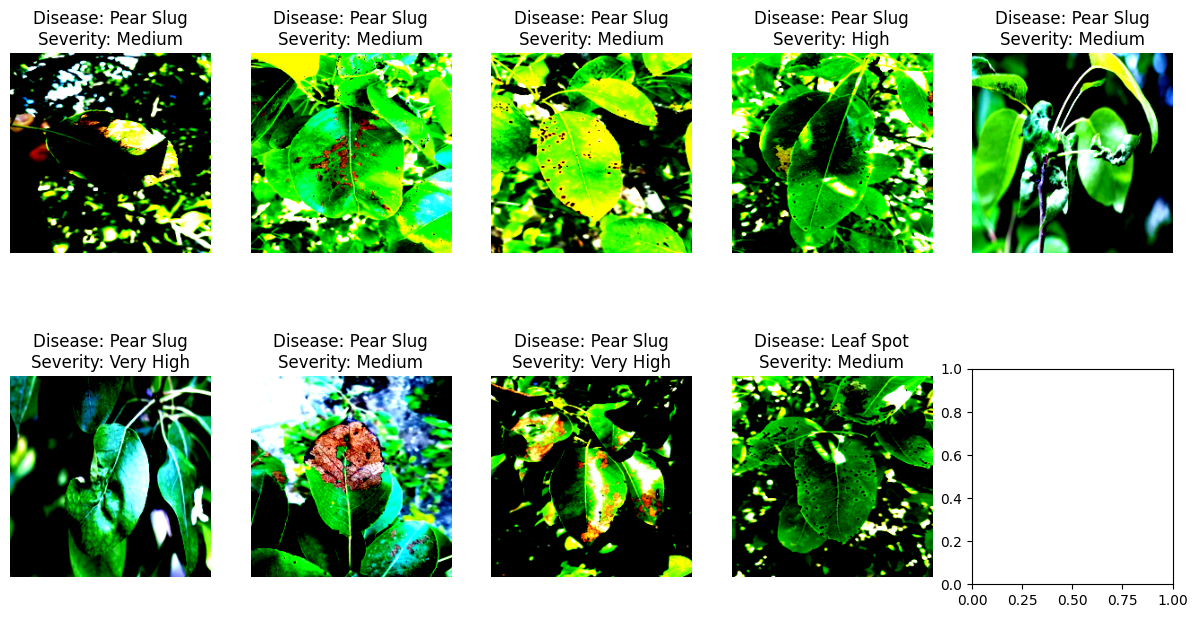

In [31]:
# Convert lists to numpy arrays
correct_images = np.array(correct_images)
correct_disease_labels = np.array(correct_disease_labels)
correct_severity_labels = np.array(correct_severity_labels)
correct_disease_predictions = np.array(correct_disease_predictions)
correct_severity_predictions = np.array(correct_severity_predictions)

# Show correctly classified images along with their predictions
num_images_to_show = min(10, len(correct_images))
random_indices = np.random.choice(len(correct_images), num_images_to_show, replace=False)

fig, axs = plt.subplots(2, (num_images_to_show + 1) // 2, figsize=(15, 7))
fig.subplots_adjust(hspace=0.5)

for i in range(num_images_to_show):
    ax = axs.flat[i]
    idx = random_indices[i]
    image = correct_images[idx]
    disease_label = ["Healthy", "Pear Slug", "Leaf Spot", "Curl"][correct_disease_predictions[idx]]
    severity_label = ["None", "Low", "Medium", "High", "Very High"][correct_severity_predictions[idx]]
    
    ax.imshow(np.moveaxis(image, 0, -1))  # Convert from (C, H, W) to (H, W, C)
    ax.set_title(f"Disease: {disease_label}\nSeverity: {severity_label}")
    ax.axis("off")

# Log the image and its labels to wandb
wandb.log({"correctly_classified_images": [wandb.Image(np.moveaxis(image, 0, -1), 
                                                     caption=f"Disease: {disease_label}\nSeverity: {severity_label}") 
                                           for image in correct_images[random_indices]]})

plt.show()

In [ ]:
wandb.finish()